# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

Подключаем библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

Загрузим данные из файла users_behavior.csv, выведем первые 10 строк таблицы для первого взгляда на данные.
Также с помощью метода info() изучим структуру таблицы: типы данных, количество строк, столбцов, пропущенных данных.

In [2]:
# читаем данные из .csv файла с помощью метода read_csv()
users = pd.read_csv('/datasets/users_behavior.csv')
# выведем первые 10 строк таблицы с помощью метода head()
display(users.head(10))
# с помощью метода info() изучим структуры таблицы: типы данных, количество строк, столбцов, пропущенных данных.
users.info()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


В таблице данных 3214 объектов. Пропусков нет.
В столбцах calls и messages содержится целочисленная информация. Заменим тип данных в них на int64 для уменьшения занимаемого места.

In [3]:
users['calls'] = users['calls'].astype('int16')
users['messages'] = users['messages'].astype('int16')

Рассмотрим численные распределения данных в столбцах с помощью метода describe().

In [4]:
users.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


По всем признакам медиана и среднее значение не сильно отличаются друг от друга. Перекоса в данных почти не наблюдается.
Построим графики распределений признаков (гистограммы и boxplot)

In [5]:
def show_hists(data, data_label, num_bins, rug=False, log_scale=False):
    """
    input: data - данные для построения гистограммы
           data_label - описание данных
           num_bins - количество ячеек
    output: None
    description: Функция строит гистограмму и boxplot для выбранного параметра:
                - Плотность распределения (методом distplot() библиотеки seaborn)
                - Boxplot (метод boxplot() библиотеки seaborn)
    """
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].set_title(data_label + ". Плотность распределения", fontsize=18)
    axes[0].set_ylabel('плотность', fontsize=15)
    sns.distplot(data, bins=num_bins, rug=rug, ax=axes[0])
    axes[1].set_title(data_label + ". Boxplot", fontsize=18)
    sns.boxplot(data=users, x=data_label, ax=axes[1])
    plt.show()

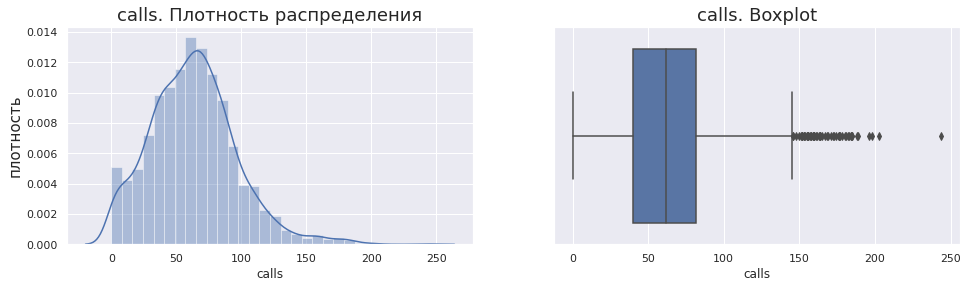

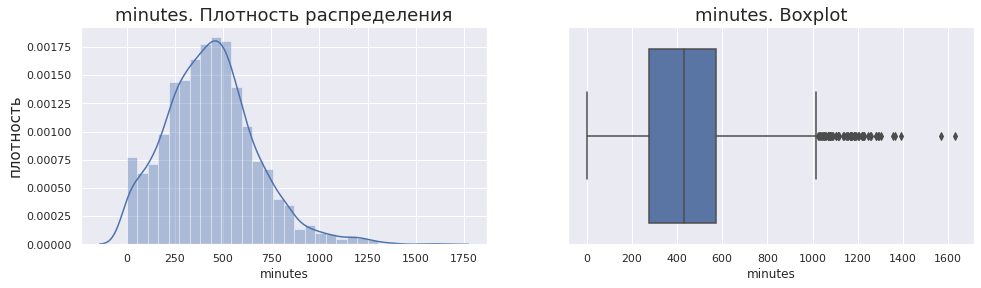

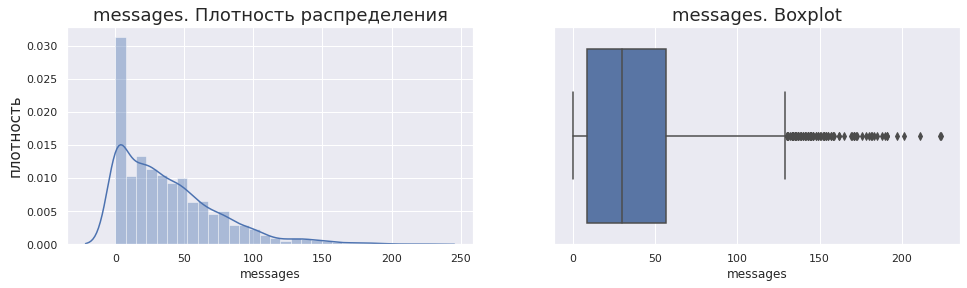

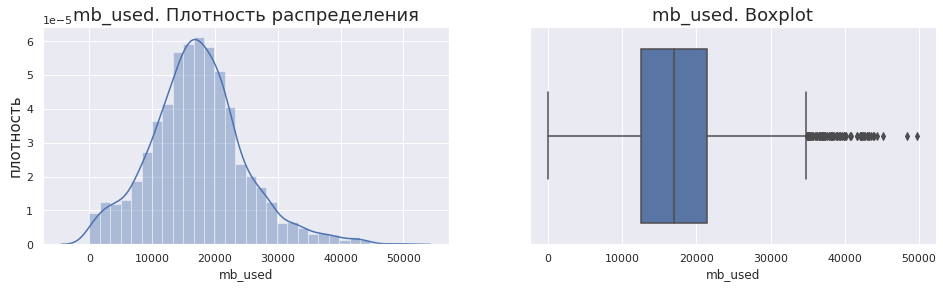

In [6]:
for column in users.drop('is_ultra', axis=1).columns:
    show_hists(users[column], column, num_bins=30)

Стоит отметить, что признак messages для многих объектов = 0. Это вносит небольшой скос данных влево.

In [7]:
zero_mes_rate = round(len(users.loc[users['messages'] == 0]) / len(users) * 100, 2)
print('Доля пользователей, не отправляющих сообщения: {} %'.format(zero_mes_rate))

Доля пользователей, не отправляющих сообщения: 15.46 %


Определим доли выбросов по всем параметрам.

In [8]:
def outliers_rate(data, column):
    """
    input: data - таблица данных
           column - признак для подсчета доли выбросов
    output: None
    description: Функция считает и выводит долю выбросов по выбранному признаку в %.
                 функция возвращает значение границы выбросов.
    """
    # квантили считаются методом quantile()
    # граница выбросов считается по формуле  [ q.75 + (q.75 - q.25)*1.5 ]
    max_val = (data[column].quantile(0.75) - data[column].quantile(0.25))*1.5 + data[column].quantile(0.75)
    rate = round(len(data.loc[data[column] > max_val]) / len(data) * 100, 2)
    print('Доля выбросов в параметре {}: {} %'.format(column, rate))
    return max_val

In [9]:
# в переменной max_vals будем хранить границы выбросов по признакам
max_vals = []
# считаем границы выбросов по всем признакам и выводим доли выбросов по отдельным признакам
for column in users.drop('is_ultra', axis=1).columns:
    max_vals.append(outliers_rate(users, column))

# считаем общую долю выбросов по всем признакам.
whole_rate = len(users.loc[(users['calls'] > max_vals[0]) | 
                (users['minutes'] > max_vals[1]) | 
                (users['messages'] > max_vals[2]) | 
                (users['mb_used'] > max_vals[3]) 
                          ]) / len(users)
print('Общая доля выбросов: {} %'.format(round(whole_rate*100, 2)))

Доля выбросов в параметре calls: 1.93 %
Доля выбросов в параметре minutes: 1.9 %
Доля выбросов в параметре messages: 2.83 %
Доля выбросов в параметре mb_used: 2.4 %
Общая доля выбросов: 6.47 %


Выбросов достаточно много (около 6.5%). Не будем их удалять.

Вывод: Данные успешно загружены и проанализированы. Таблица данных содержит 3214 объектов, пропусков нет.
Типы данных признаков calls и messages заменены на целочисленный int64.
Сильного перекоса в распределениях признаков не наблюдается.
Общая доля выбросов составляет 6.5%. Выбросы не удалены.

## Разбейте данные на выборки

Для начала выделим в исходных данных:

признаки: calls, minutes, messages, mb_used

целевой признак: is_ultra

In [10]:
features = users.drop('is_ultra', axis=1)
target = users['is_ultra']

Разделим данные на обучающую, валидационную и тестовую выборки в пропорции 3:1:1 соответственно (60% на обучающию и по 20% данных на валидационную и тестовую выборки).

In [11]:
# разделение проведём с помощью функции train_test_split библиотеки sklearn
X, X_test, y, y_test = train_test_split(features, target, test_size=0.2, random_state=123)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=123)

## Исследуйте модели

3.1. Решающее дерево

Инициируем модель решающего дерева DecisionTreeClassifier

Выделим гиперпараметры для настройки модели:

max_depth - максимальная глубина древа

min_samples_split - минимальное количество объектов в узле

min_samples_leaf - минимальное количество объектов в листе

criterion ("gini" или "entropy") - функция измерения качества разделения

Критерием проверки качества модели будет точность accuracy

In [12]:
# в параметрах best_params и best_accuracy будем хранить наилучшие параметры для модели и наивысшую точность соответственно
best_params = []
best_accuracy = 0
# проходим в циклах по всем выбранным гиперпараметрам
for max_depth in range(2,10):
    for min_samples_split in range(2,6):
        for min_samples_leaf in range(1,10):
            for criterion in ['gini', 'entropy']:
                # инициация модели с текущими гиперпараметрами
                model_dt_clf = DecisionTreeClassifier(random_state=123,
                                                      max_depth=max_depth,
                                                      min_samples_split=min_samples_split,
                                                      min_samples_leaf=min_samples_leaf,
                                                      criterion=criterion)
                # обучение модели на тренировочной выборке
                model_dt_clf.fit(X_train, y_train)
                # поиск предсказаний модели на валидационной выбоке
                predictions = model_dt_clf.predict(X_valid)
                # вычисление точности модели методом accuracy_score
                accuracy = accuracy_score(y_valid, predictions)
                # если текущее значение точности выше предыдущего лучшего значения, 
                # сохраняем параметры модели и текущую точность
                if accuracy > best_accuracy:
                    best_params = [max_depth, min_samples_split, min_samples_leaf, criterion]
                    best_accuracy = accuracy

In [13]:
# вывод наилучшей точности и параметров модели.
print('''Наилучшая точность: {}
Парамтеры модели:
   max_depth = {}
   min_samples_split = {}
   min_samples_leaf = {}
   criterion = {} '''.format(round(best_accuracy, 2),
                             best_params[0],
                             best_params[1],
                             best_params[2],
                             best_params[3]
                            ))

Наилучшая точность: 0.79
Парамтеры модели:
   max_depth = 6
   min_samples_split = 2
   min_samples_leaf = 5
   criterion = entropy 


Данная модель уже удовлетворяет условиям технического задания. Попробуем улучшить результат с другими моделями.

3.2. Случайный лес

Инициируем модель случайного леса RandomForestClassifier

Выделим гиперпараметры для настройки модели:
    
n_estimators - количество деревьев

max_depth - максимальная глубина древа

min_samples_split - минимальное количество объектов в узле

min_samples_leaf - минимальное количество объектов в листе

criterion ("gini" или "entropy") - функция измерения качества разделения

Критерием проверки качества модели будет точность accuracy.

In [22]:
# в параметрах best_params и best_accuracy будем хранить наилучшие параметры для модели и наивысшую точность соответственно
best_params = []
best_accuracy = 0
# проходим в циклах по всем выбранным гиперпараметрам
for n_estimators in (1,10):
    for max_depth in range(2,10):
        for min_samples_split in range(2,10):
            for min_samples_leaf in range(1,8):
                for criterion in ['gini', 'entropy']:
                    # инициация модели с текущими гиперпараметрами
                    model_rf_clf = RandomForestClassifier(random_state=123,
                                                          n_estimators=n_estimators,
                                                          max_depth=max_depth,
                                                          min_samples_split=min_samples_split,
                                                          min_samples_leaf=min_samples_leaf,
                                                          criterion=criterion)
                    # обучение модели на тренировочной выборке
                    model_rf_clf.fit(X_train, y_train)
                    # поиск предсказаний модели на валидационной выбоке
                    predictions = model_rf_clf.predict(X_valid)
                    # вычисление точности модели методом accuracy_score
                    accuracy = accuracy_score(y_valid, predictions)
                    # если текущее значение точности выше предыдущего лучшего значения, 
                    # сохраняем параметры модели и текущую точность
                    if accuracy > best_accuracy:
                        best_params = [n_estimators, max_depth, min_samples_split, min_samples_leaf, criterion]
                        best_accuracy = accuracy

In [23]:
# вывод наилучшей точности и параметров модели.
print('''Наилучшая точность: {}
Парамтеры модели:
   n_estimators = {}
   max_depth = {}
   min_samples_split = {}
   min_samples_leaf = {}
   criterion = {} '''.format(round(best_accuracy, 2),
                             best_params[0],
                             best_params[1],
                             best_params[2],
                             best_params[3],
                             best_params[4]
                            ))

Наилучшая точность: 0.81
Парамтеры модели:
   n_estimators = 10
   max_depth = 9
   min_samples_split = 6
   min_samples_leaf = 2
   criterion = gini 


Точность в модели случайного леса удалось увеличить на 2% по сравнению с решающим деревом.

3.3. Логистическая регрессия

Инициируем модель логистической регрессии LogisticRegression

Выделим гиперпараметры для настройки модели:

С - инверсия силы регуляризации

Критерием проверки качества модели будет точность accuracy.

In [24]:
# в параметрах best_params и best_accuracy будем хранить наилучшие параметры для модели и наивысшую точность соответственно
best_params = []
best_accuracy = 0

cs = np.linspace(0.01, 10, 1000, endpoint=True)
# проходим в циклах по всем выбранным гиперпараметрам
for C in cs:
    # инициация модели с текущими гиперпараметрами
    model_lr_clf = LogisticRegression(random_state=123,
                                      C=C,
                                      max_iter=1000)
    # обучение модели на тренировочной выборке
    model_lr_clf.fit(X_train, y_train)
    # поиск предсказаний модели на валидационной выбоке
    predictions = model_lr_clf.predict(X_valid)
    # вычисление точности модели методом accuracy_score
    accuracy = accuracy_score(y_valid, predictions)
    # если текущее значение точности выше предыдущего лучшего значения, 
    # сохраняем параметры модели и текущую точность
    if accuracy > best_accuracy:
        best_params = [C]
        best_accuracy = accuracy

In [25]:
# вывод наилучшей точности и параметров модели.
print('''Наилучшая точность: {}
Парамтеры модели:
   C = {} '''.format(round(best_accuracy, 2),
                             best_params[0]
                            ))

Наилучшая точность: 0.73
Парамтеры модели:
   C = 0.01 


Логистическая регрессия даёт более низкую точность, чем решающее дерево и случайный лес.

## Проверьте модель на тестовой выборке

По критерию accuracy наилучшей точности удалось достичь с моделью Случайного леса

Наилучшая точность: 0.81

Парамтеры модели: n_estimators = 10

max_depth = 9

min_samples_split = 6

min_samples_leaf = 2

criterion = gini

Проведём обучение данной модели на всех доступных данных (обучающие + валидационные) и вычислим точность на тестовой выборке.

In [26]:
model_rf_clf = RandomForestClassifier(random_state=123,
                                      n_estimators=10,
                                      max_depth=9,
                                      min_samples_split=6,
                                      min_samples_leaf=2,
                                      criterion='gini')
model_rf_clf.fit(X, y)
predictions = model_rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print('Точность модели на тестовой выборке: {}'.format(round(accuracy, 2)))

Точность модели на тестовой выборке: 0.81


Вывод: Были проанализированы различные классификационные модели: Решающее дерево, Случайный лес, Логистическая регрессия, 
Каждая модель была обучена для различных сочетаний гиперпараметров; выведены наилучшие варианты для каждой модели.
Наилучшая точность (accuracy) была достигнута для модели Случайного леса:
Accuracy на валидационной выборке: 0.81
Accuracy на тестовой выборке: 0.81

## (бонус) Проверьте модели на адекватность

Для модели случайного леса посмотрим подробнее на зависимость точности от числа деревьев и максимальной глубины дерева.

In [27]:
accuracy_df = pd.DataFrame(columns=['n_estimators', 'max_depth', 'accuracy'])
for n_est in range(2, 31):
    for m_depth in range(2, 11):
        model_rf_clf = RandomForestClassifier(random_state=123,
                                      n_estimators=n_est,
                                      max_depth=m_depth)
        model_rf_clf.fit(X, y)
        predictions = model_rf_clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        accuracy_df = accuracy_df.append({'n_estimators': n_est,
                                          'max_depth': m_depth,
                                          'accuracy': accuracy}, ignore_index=True)

In [28]:
display(accuracy_df.head(10))

,n_estimators,max_depth,accuracy
0,2.0,2.0,0.748056
1,2.0,3.0,0.769829
2,2.0,4.0,0.797823
3,2.0,5.0,0.794712
4,2.0,6.0,0.811820
5,2.0,7.0,0.788491
6,2.0,8.0,0.780715
7,2.0,9.0,0.776050
8,2.0,10.0,0.776050
9,3.0,2.0,0.755832


Представим данные таблицы accuracy_df в виде сводной таблицы и построим heatma

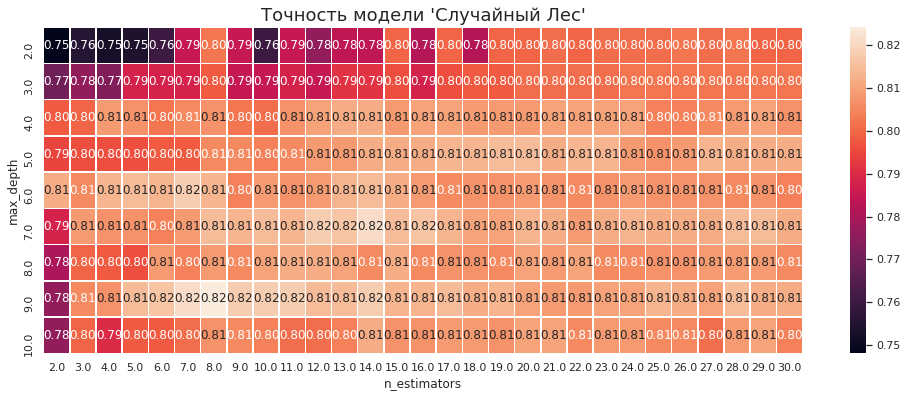

In [29]:
accuracy_pivot = accuracy_df.pivot("max_depth", "n_estimators", "accuracy")
f, ax = plt.subplots(figsize=(17, 6))
sns.heatmap(accuracy_pivot, annot=True, fmt=".2f", linewidths=.5, ax=ax)
ax.set_title("Точность модели 'Случайный Лес'", fontsize=18)
plt.show()

По данному графику видно, что одно из максимальных значений точности (accuracy=0.82) модель достигает при max_depth=6 и n_estimators=7. Нет смысла далее увеличивать значения этих параметров.

## Общий вывод

1) Данные успешно загружены и проанализированы.
Пропусков не обнаружено, типы данных преобразованы в соответствии с хранимой информацией.
Сильного перекоса в распределениях признаков не наблюдается.
Общая доля выбросов составляет 6.5%. Выбросы не удалены.

2) Были проанализированы различные классификационные модели: Решающее дерево, Случайный лес, Логистическая регрессия. Модели обучены на различных сочетаниях гиперпараметров.

Наилучшая точность (accuracy) была достигнута для модели Случайного леса:
Accuracy на тестовой выборке: 0.81

3) Изменение точности Модели 'Случайный лес' было проанализировано при изменении числа деревьев и максимальной глубины дерева.

Максимального значения точности (accuracy=0.82) модель достигает при max_depth=6 и n_estimators=7. Нет смысла далее увеличивать значения этих параметров.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
